In [2]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np 
from typing import Tuple, List
from torch.utils.data import DataLoader, TensorDataset
from torch import nn as nn 
from torch.optim import Adam
import random

# Set seeds for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Dataset Creation and Preprocessing

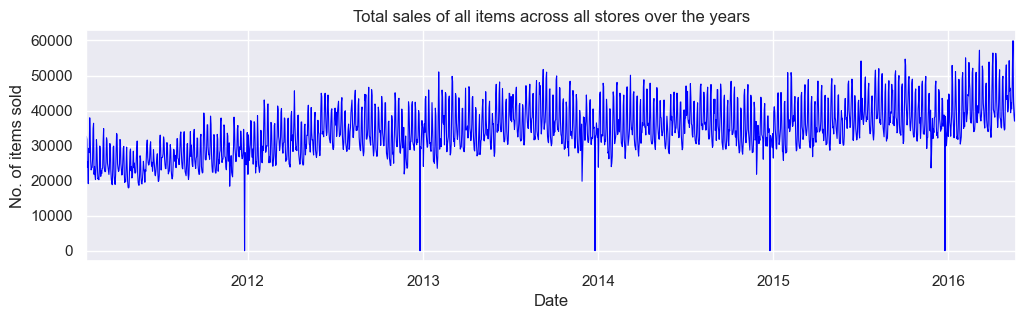

In [3]:
# Read CSV
calender_df = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
sales_eval_df = pd.read_csv('m5-forecasting-accuracy/sales_train_evaluation.csv')

# Clean and preprocess sales data
sales_eval_df['id'] = sales_eval_df['id'].str.replace('_evaluation', '') # Standardize 'id' by removing '_evaluation'
sales_eval_df = sales_eval_df.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id','state_id']) # Remove non-essential columns
sales_eval_df = sales_eval_df.set_index('id') # Set 'id' names as index
sales_eval_df.index.name = None

# Ensure no duplicate rows
assert sales_eval_df.duplicated().sum() == 0 
assert calender_df.duplicated().sum() == 0

# Reshape sales data for time-series analysis
daywise_sale = sales_eval_df.T  # Daywise sale for each item
daywise_sale['d'] = daywise_sale.index # Add 'd' column to align with calendar data

# Keep relevant calender information
calender_df_1 = calender_df[['date', 'd']] 

# Merge sales data with calender dates
df = calender_df_1.merge(daywise_sale, on='d')  

# Convert 'date' column to datetime format for proper time-series handling
df['date'] = pd.to_datetime(df['date']) 

# Set 'date' as the index for time-series analysis
df = df.set_index('date')

# Plot total sales trend over time
df.iloc[:, 1:].sum(axis=1).plot(kind='line',linestyle='-', lw=0.8, figsize=(12,3), 
                                colormap='bwr',  title='Total sales of all items across all stores over the years', 
                                ylabel='No. of items sold', xlabel='Date' )
plt.show()

### Univariate (single feature) analysis
- Predict sales for an item based on previous 'n' day sales. 'n' is sequence length.

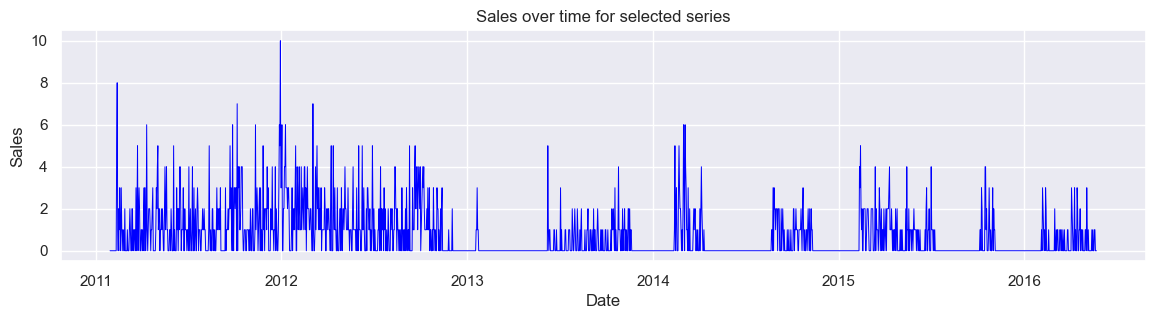

In [4]:
# Plot sales time series for a specific item
item_index = 30000  # Index of the selected item

plt.figure(figsize=(14,3))  
plt.plot(df.index, df.iloc[:,item_index], linestyle='-', lw=0.7, color='blue')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales over time for selected series')
plt.show()

- For this we will create dataset of shape [seq_len, 1]. For an input sequence of past 'n' days the target will be 'n+1' day's sale.

In [5]:
# Normalize sales data for the selected item using Min-Max Scaling
df_uv = np.array(df.iloc[:, item_index]) # Extract sales data for the selected item
scaler = MinMaxScaler(feature_range=(-1,1))  # Scale data to range [-1,1]
df_scaled = scaler.fit_transform(df_uv.reshape(-1,1)) # Repshape and apply scaling
print(f"{df_scaled[:5]=}, \n {df_scaled[-5:]=}") # Ensure the scaled data lie between (-1,1)

df_scaled[:5]=array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]]), 
 df_scaled[-5:]=array([[-0.8],
       [-0.8],
       [-1. ],
       [-1. ],
       [-1. ]])


### Sequence creation

In [6]:
# Generate input-output sequences for time series forecasting
def create_seq(data: np.ndarray, seq_len: int) -> Tuple [np.ndarray, np.ndarray]:
    X: List = []
    y: List = []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])  # Extract input sequence
        y.append(data[i+seq_len])    # Assign the corresponding target value
    return np.array(X), np.array(y)

assert type(df_scaled) == np.ndarray # Ensure the dataset is in NumPy array format

# Define sequence length and create input-target pairs
seq_len=30
X, y = create_seq(df_scaled, seq_len)
print(f"{X.shape=}, {y.shape=}") # Ensure shapes of input and target

X.shape=(1911, 30, 1), y.shape=(1911, 1)


In [7]:
# Split dataset into training, validation, and test sets

total_len: int = len(X)

# Define training set indices as 80% of data
train_index: int = int(total_len*0.8)
X_train, y_train = X[:train_index], y[:train_index]

# Define validation set indices (next 10% of data)
val_index: int = train_index+int(0.1*total_len)
X_val, y_val = X[train_index:val_index], y[train_index:val_index]

# Assign remaining 10% of data to the test set
X_test, y_test = X[val_index:], y[val_index:]

### Create tensors

In [8]:
# Create numpy arrays to pytorch tensors
def create_tensor(data: np.ndarray, dtype: torch.dtype)-> torch.Tensor:
    return torch.tensor(data,dtype=dtype)

X_tensor, y_tensor = create_tensor(X,dtype=torch.float32), create_tensor(y, dtype=torch.float32)
X_train_tensor, y_train_tensor= create_tensor(X_train, dtype=torch.float32),  create_tensor(y_train, dtype=torch.float32) # Convert to tensor
X_val_tensor, y_val_tensor = create_tensor(X_val, dtype=torch.float32), create_tensor(y_val, dtype=torch.float32)
X_test_tensor, y_test_tensor = create_tensor(X_test, dtype=torch.float32), create_tensor(y_test, dtype=torch.float32)

# Wrap input and target tensors into TensorDataset objects
def create_dataset(input_tensor: torch.Tensor, target_tensor: torch.Tensor)-> TensorDataset:
    return TensorDataset(input_tensor, target_tensor)
full_dataset = create_dataset(X_tensor, y_tensor)
train_dataset  = create_dataset(X_train_tensor, y_train_tensor) # Create dataset
val_dataset = create_dataset(X_val_tensor, y_val_tensor)
test_dataset = create_dataset(X_test_tensor, y_test_tensor)

# Initialize DataLoader for batch processing in DL
def get_dataloader(data: TensorDataset, batch_size: int) -> DataLoader:
    return DataLoader(dataset=data, batch_size=batch_size)
batch_size=128  
full_dataloader = get_dataloader(full_dataset, batch_size)

train_dataloader= get_dataloader(train_dataset, batch_size)
val_dataloader= get_dataloader(val_dataset, batch_size)
test_dataloader = get_dataloader(test_dataset, batch_size)

# Verify shape of input and target tensors in a batch
for input, target in train_dataloader:
    print(f"{input.shape=}") # Expected: (batch_size, seq_len, num_features)
    print(f"{target.shape=}") # Expected: (batch_size, num_class)
    break

input.shape=torch.Size([128, 30, 1])
target.shape=torch.Size([128, 1])


### LSTM model

In [9]:
# Define LSTM model for sales prediction
class SalesLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float=0):
        """
        Initialize the SalesLSTM model.
        Parameters:
        - input_size: Number of input features per time step.
        - hidden_size: Number of units in the hidden layers.
        - num_layers: Number of LSTM layers.
        - output_size: Number of outputs from final layer.
        - dropout: Dropout rate to prevent overfitting.
        """
        super(SalesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.dropouts = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers,
                            batch_first=True, 
                            dropout=dropout)  # Define LSTM layer
        self.fc = nn.Linear(hidden_size,1) # Fully connected layer to generate final output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.
        Parameters:
        - x: Input tensor of shape (batch_size, sequence_length, input_size).
        Returns:
        - Predicted sales values.
        """
        all_hs_out, (h_n, c_n) = self.lstm(x)  # LSTM forward pass
        final_hidden_state = self.fc(all_hs_out[:, -1])  # Apply dropout and pass the final hidden state through the linear layer
        return final_hidden_state

In [10]:
# Hyperparameters
input_size = 1 # Only one feature per time step (daily sales of item HOUSEHOLD_1_294 at store_id CA_4)
hidden_size = 16 # Number of LSTM units
num_layers = 1 # Number of LSTM layers

# Create model instance
model= SalesLSTM(input_size, hidden_size, num_layers) 
print(f"{model=}")

# Define loss and optimization functions
criterion = nn.MSELoss()  # Mean Squared Error for regression problems
lr = 0.08
optimizer = Adam(model.parameters(), lr=lr)  # Adam optimizer for adaptive learning

# Training model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Iterate over training data batches
    for input, target in train_dataloader:
        optimizer.zero_grad()  # Clean previous gradients
        # print(input.shape)
        output = model(input)  # Forward pass
        loss = criterion(output, target) # Compute loss
        loss.backward()  # Find gradients by backpropagation
        optimizer.step() # Update model weights 
        total_loss+=loss.item() # Collect total loss for a batch
    avg_loss = total_loss/len(train_dataset) # Avg training loss per batch

    # Print training loss every 5 epochs
    if epoch%5==0:
        print(f"Epoch: {epoch}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

    # Evaluate model on valiation data
    model.eval()  # Set model to evaluation mode to drop dropout
    total_val_loss = 0

    with torch.no_grad():  # Ensure no gradient updates 
        for input, target in val_dataloader:  
            output = model(input) # Forward pass
            val_loss = criterion(output, target) # Find valiadtion loss
            total_val_loss += val_loss.item()
   
    avg_val_loss = total_val_loss/len(val_dataset)
    if epoch%10==0:
        print(f"\t     Avg val loss: {avg_val_loss:.4f}")


model=SalesLSTM(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
Epoch: 0/50, Avg Loss: 0.0021
	     Avg val loss: 0.0008
Epoch: 5/50, Avg Loss: 0.0006
Epoch: 10/50, Avg Loss: 0.0006
	     Avg val loss: 0.0003
Epoch: 15/50, Avg Loss: 0.0005
Epoch: 20/50, Avg Loss: 0.0005
	     Avg val loss: 0.0003
Epoch: 25/50, Avg Loss: 0.0005
Epoch: 30/50, Avg Loss: 0.0005
	     Avg val loss: 0.0003
Epoch: 35/50, Avg Loss: 0.0004
Epoch: 40/50, Avg Loss: 0.0004
	     Avg val loss: 0.0003
Epoch: 45/50, Avg Loss: 0.0004


1911 1911


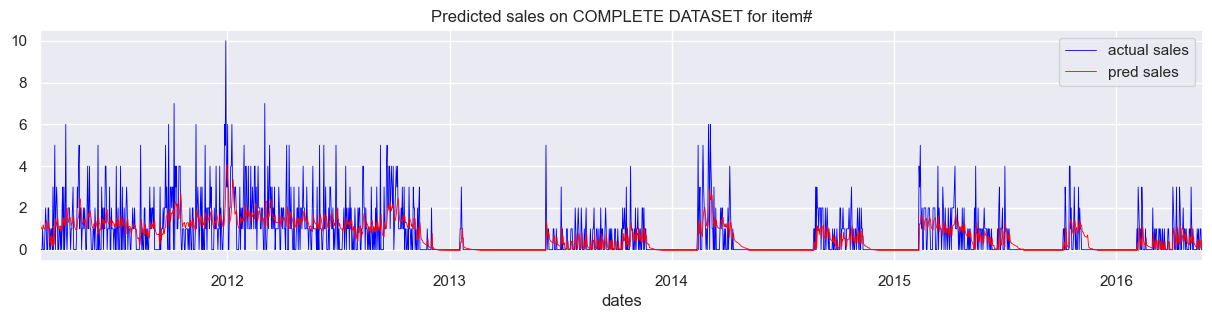

In [11]:
# Evaluate model performance on the full dataset
model.eval()  # Set model to evaluation mode
full_loss = 0
actual_output_full = []
predicted_output_full = []
with torch.no_grad():  # Disable gradient calculation
    for input, target in full_dataloader:
        output = model(input)  # Forward pass
        predicted_output_full.extend(output.numpy().flatten().tolist()) # Store predictions
        actual_output_full.extend(target.detach().numpy().reshape(-1).tolist()) # Store actual values

# Reverse normalization to obtain original scale values
predicted_unscaled_full= (scaler.inverse_transform(np.array(predicted_output_full).reshape(-1,1)).reshape(-1)).tolist()
actual_unscaled_full = (scaler.inverse_transform(np.array(actual_output_full).reshape(-1,1)).reshape(-1)).tolist()
print(len(predicted_unscaled_full), len(actual_unscaled_full)) # Validate data lengths

# Create a DataFrame to compare actual vs. predicted sales
full_df= pd.DataFrame({'actual sales': actual_unscaled_full, 'pred sales':predicted_unscaled_full, 'dates': df[seq_len:].index})
full_df = full_df.set_index('dates')

# Plot actual vs. predicted sales over time
full_df.plot(kind='line', figsize=(15,3), colormap='bwr', linestyle='-', lw=0.6, title='Predicted sales on COMPLETE DATASET for item#')
plt.show()

Test Loss: 0.0213


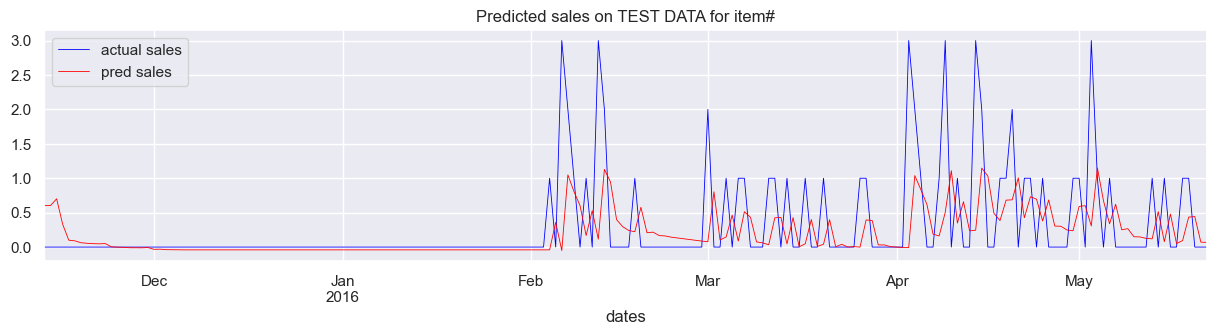

In [12]:
# Evaluate model performance on the test set
model.eval()  # Set model to evaluation mode
test_loss = 0
actual_output = []
predicted_output = []
with torch.no_grad():  # Disable gradient calculation
    for input, target in test_dataloader:
        output = model(input)  # Forward pass
        predicted_output.extend(output.numpy().flatten().tolist()) # Store predicted values
        actual_output.extend(target.detach().numpy()) # Store actual values
        loss = criterion(output, target) # Compute test loss
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_dataloader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Reverse normalization to obtain actual scale values
predicted_unscaled = scaler.inverse_transform(np.array(predicted_output).reshape(-1,1)).reshape(-1).tolist()
actual_unscaled = scaler.inverse_transform(np.array(actual_output).reshape(-1,1)).reshape(-1).tolist()

# Create a DataFrame for actual vs. predicted sales
test_df= pd.DataFrame({'actual sales': actual_unscaled, 'pred sales':predicted_unscaled, 'dates': df[val_index+seq_len:].index})
test_df = test_df.set_index('dates')

# Plot actual vs. predicted sales over time
test_df.plot(kind='line', figsize=(15,3), colormap='bwr', linestyle='-', lw=0.6, title='Predicted sales on TEST DATA for item#')
plt.show()

In [13]:
# Correlation between actual and predicted sales in test data
r_value = np.corrcoef(test_df['actual sales'], test_df['pred sales'])[0, 1]
print("Correlation Coefficient (R-value):", r_value)

Correlation Coefficient (R-value): 0.29441159014195634


- Correlation coefficient is very small but from plot we can see that the prediction is following the sales trend with some lag.
- To resolve this issue the number of features should be increased.
- Create following new features:
  1. Lag features with lags : [1,7,14,28,180,365]
  2. Rolling windows mean and standard deviations for windows: [1,7,14,28,180,365]
  3. Weekends binary class: [True, false]
  4. Event type categories: [Religious, National, Cultural, Sporting, No event]

- Check `multuvariate.ipynb` notebook for further analysis.